In [15]:
import sys 
sys.path.append('../..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import numpy as np
import os
import IPython
import torch as ch
from torch import Tensor
from torch.distributions import Uniform
from torch.distributions.transforms import SigmoidTransform
from torch.distributions.transformed_distribution import TransformedDistribution
from torch.utils.data import DataLoader
from delphi.stats.truncated_logistic_regression import truncated_logistic_regression
from delphi.oracle import Left, Interval
import delphi.utils.constants as consts
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

# Helpers

In [13]:
STORE_PATH = '/home/gridsan/stefanou/TruncatedLogisticRegression'
STORE_TABLE_NAME = 'log_cos'

## Default Experiment Parameters

In [23]:
# regression parameters
NUM_SAMPLES, DIMS = 10000, 2
LOWER, UPPER = -1, 1

# procedure hyperparameters
args = Parameters({ 
    'epochs': 25,
    'workers': 0, 
    'batch_size': 10,
    'bias': True,
    'num_samples': 1000,
    'clamp': True, 
    'radius': 5.0, 
    'lr': 1e-2,
    'shuffle': False, 
    'tol': 5e-2,
    'eps': 1e-5,
    'score': True,
    'custom_lr_multiplier': consts.COSINE,
    'var': True,
})

# Logistic Distribution

In [24]:
# define logistic distribution
base_distribution = Uniform(0, 1)
transforms_ = [SigmoidTransform().inv]
logistic = TransformedDistribution(base_distribution, transforms_)

In [25]:
# create store
store = Store(STORE_PATH)

store.add_table(STORE_TABLE_NAME, { 
    'delphi_cos': float,
    'mle_cos': float,
    'alpha': float, 
    'C': float,
})

# perform each experiment a total of 10 times
for iter_ in range(10): 
    for C in [-2, -1.75, -1.5, -1.25, -1, -.75, -.5, -.25]:
        PREDICATE = Left(Tensor([C]))
        args.__setattr__('phi', PREDICATE)
        # generate random uniform weights
        W = Uniform(LOWER, UPPER).sample(ch.Size([DIMS, 1]))
        W0 = Uniform(LOWER, UPPER).sample(ch.Size([1, 1]))

        # generate data
        X = Uniform(-100, 100).sample(ch.Size([NUM_SAMPLES, DIMS]))
        z = X.mm(W) + W0 + logistic.sample(ch.Size([NUM_SAMPLES, 1]))
        y = ch.where(z > 0, ch.ones(1), ch.zeros(1))
        # truncate
        indices = PREDICATE(z).nonzero(as_tuple=False).flatten()
        z_trunc, y_trunc, x_trunc = z[indices], y[indices], X[indices]

        args.__setattr__('alpha', Tensor([y_trunc.size(0) / NUM_SAMPLES]))

        # truncated logistic regression
        trunc_log_reg = truncated_logistic_regression(args.phi, args.alpha, args)
        results = trunc_log_reg.fit(x_trunc, y_trunc)
        w, w0 = results.weight.detach().cpu(), results.bias.detach().cpu()
        
        # naive estimates 
        naive_log_reg = LogisticRegression()
        naive_log_reg.fit(x_trunc, y_trunc.flatten())

        # parameter estimates 
        real_params = ch.cat([W.T, W0], axis=1)
        mle_params = ch.cat([Tensor(naive_log_reg.coef_), Tensor(naive_log_reg.intercept_).unsqueeze(0)], axis=1)
        delphi_params = ch.cat([w, w0.unsqueeze(0)], axis=1)

        store[STORE_TABLE_NAME].append_row({ 
            'delphi_cos': cosine_similarity(delphi_params, real_params),
            'mle_cos': cosine_similarity(mle_params, real_params),
            'alpha': float(args.alpha),
            'C': C,
        })
        
        IPython.display.clear_output(wait=False)

# close current store
store.close()

# Results

In [26]:
reader = CollectionReader(STORE_PATH)
results = reader.df(STORE_TABLE_NAME)
reader.close() # close reader
results.head()

100%|██████████| 1/1 [00:00<00:00, 134.71it/s]


,delphi_cos,mle_cos,alpha,C,exp_id
0,0.687608,0.973525,0.5110,-2.00,1e5364d8-53ac-4b02-a35e-aa00dbb6ed44
1,0.942725,0.972733,0.5202,-1.75,1e5364d8-53ac-4b02-a35e-aa00dbb6ed44
2,0.983033,0.745000,0.5156,-1.50,1e5364d8-53ac-4b02-a35e-aa00dbb6ed44
3,0.840633,-0.030077,0.4994,-1.25,1e5364d8-53ac-4b02-a35e-aa00dbb6ed44
4,0.393021,0.834648,0.5187,-1.00,1e5364d8-53ac-4b02-a35e-aa00dbb6ed44


# All Trials

all trials:


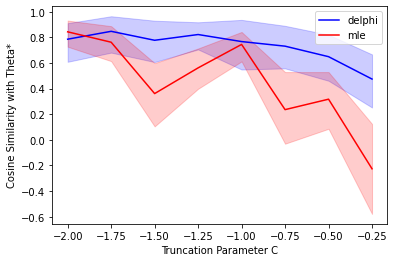

In [27]:
print("all trials:")

# variance vs param mse
sns.lineplot(data=results, x='C', y='delphi_cos', label='delphi', color='blue')
ax = sns.lineplot(data=results, x='C', y='mle_cos', label='mle', color='red')
ax.set(xlabel='Truncation Parameter C', ylabel='Cosine Similarity with Theta*')
plt.show()